In [2]:
# %load_ext autoreload
# %autoreload 2
import sys
sys.path.append("..")
import pandas as pd
import numpy as np
from pathlib import Path
import torch as th
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
from tools.utils import load_latent_df, push_latent_df, apply_masks
from tools.cc_utils import chat_only_latent_indices, base_only_latent_indices, shared_latent_indices
from tools.latent_scaler.plot import plot_scaler_histograms
from tools.latent_scaler.utils import load_betas, get_beta_from_index
from tools.paths import *


results_dir = DATA_ROOT / "results" / "closed_form_scalars"

max_activation_path = Path("/workspace/data/max_activations_N50000000.pt")
max_activations = th.load(max_activation_path)

/tmp/ipykernel_140973/1374852297.py:23: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  max_activations = th.load(max_activation_path)


In [3]:
configs = {
    "normal": {
        model: {
            target: (f"{model}_{target}", "") for target in ["error", "reconstruction"]
        }
        for model in ["base", "it"]
    },
}

shared_configs = {
    "normal": {
        model: {
            target: (f"{model}_{target}", "") for target in ["reconstruction", "error"]
        }
        for model in ["base", "it"]
    },
}
def load_results(base_path, configs, not_dead_mask=None, to_numpy=True):
    betas_out = {
        config: {
            model: {
                target: None for target in configs[config][model]
            } for model in configs[config]
        } for config in configs
    }
    count_active_out = {
        config: {
            model: {
                target: None for target in configs[config][model]
            } for model in configs[config]
        } for config in configs
    }
    for config in configs:
        for model in configs[config]:
            for target in configs[config][model]:
                betas, count_active = load_betas(base_path, computation=configs[config][model][target][0], suffix=configs[config][model][target][1])
                betas = betas.cpu()
                count_active = count_active.cpu()
                if to_numpy:
                    betas = betas.numpy()
                    count_active = count_active.numpy()
                if not_dead_mask is not None:
                    betas = betas[not_dead_mask]
                    count_active = count_active[not_dead_mask]
                betas_out[config][model][target] = betas
                count_active_out[config][model][target] = count_active
    return betas_out, count_active_out


def compute_ratios(betas):
    reconstruction_ratio = betas["normal"]["base"]["reconstruction"] / betas["normal"]["it"]["reconstruction"]
    error_ratio = betas["normal"]["base"]["error"] / betas["normal"]["it"]["error"]
    return reconstruction_ratio, error_ratio


## Connor CrossCoder

In [3]:
name = "ckkissane_crosscoder-gemma-2-2b-model-diff"

all_results = results_dir / name
shared_indices_results = results_dir / "shared_indices" / name

PLOTS_DIR = PLOTS / VERSION / "closed_form_scalers" / name
PLOTS_DIR.mkdir(parents=True, exist_ok=True)

plots_dir = Path("/workspace/data/plots/closed_form_scalars/") / name
plots_dir.mkdir(parents=True, exist_ok=True)

df = load_latent_df("connor")

all_masks = []
latent_indices = chat_only_latent_indices("connor").numpy()
shared_indices = shared_latent_indices("connor").numpy()
base_only_indices = base_only_latent_indices("connor").numpy()
sampled_shared_indices = th.load(Path("/workspace/data/connor_sampled_shared_indices.pt")).numpy()
betas, count_active = load_results(all_results, configs)
betas_shared, count_active_shared = load_results(shared_indices_results, shared_configs)

feature_df.csv:   0%|          | 0.00/4.93M [00:00<?, ?B/s]

/tmp/ipykernel_993/3609749203.py:18: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  sampled_shared_indices = th.load(Path("/workspace/data/connor_sampled_shared_indices.pt"))

In [4]:
# Print counts of different index groups
print(f"Number of latent indices: {len(latent_indices)}")
print(f"Number of shared indices: {len(shared_indices)}")
print(f"Number of base-only indices: {len(base_only_indices)}")
print(f"Number of other indices: {len(df) - len(latent_indices) - len(shared_indices) - len(base_only_indices)}")


Number of latent indices: 265
Number of shared indices: 14652
Number of base-only indices: 98
Number of other indices: 1369


In [10]:
len(df)

16384

In [5]:
betas, count_active = load_results(all_results, configs, not_dead_mask=None)

error_ratio, reconstruction_ratio = compute_ratios(betas)
error_ratio_shared, reconstruction_ratio_shared = compute_ratios(betas_shared)

In [6]:
reconstruction_ratio_shared

array([ 7.2176856e-01,  6.8967485e-01,  6.9096404e-01,  6.5222740e-01,
        6.7307603e-01,  1.1863835e+00,  7.4184310e-01,  7.4069411e-01,
        7.4768996e-01,  6.5014780e-01,  4.4912598e-01,  7.5523251e-01,
        7.8791040e-01,  7.3876452e-01,  8.0739051e-01,  7.0601153e-01,
        6.8810171e-01,  8.2251960e-01,  9.9418682e-01,  6.1421818e-01,
        8.7726790e-01,  7.7809268e-01,  7.7768499e-01,  6.8893576e-01,
        1.2192411e+00,  7.5525832e-01,  8.5932058e-01,  6.0878378e-01,
        7.7381611e-01,  5.5417275e-01,  7.2339368e-01,  7.2066402e-01,
        6.6964322e-01,  1.2178639e+00,  7.1306866e-01,  1.6122547e+00,
        6.1127496e-01,  7.4647862e-01,  6.7135167e-01,  6.1332577e-01,
        7.6239699e-01,  7.2691858e-01,  5.9772712e-01,  6.8520987e-01,
        7.7801144e-01,  1.1625440e+00,  7.7925038e-01,  8.8984257e-01,
        6.4729822e-01,  6.3996267e-01,  1.3558415e-01,  8.4711874e-01,
        8.0317384e-01,  6.9422925e-01,  7.6099181e-01,  7.1785527e-01,
      

In [7]:
# update df
df["beta_error_base"] = np.nan
df["beta_error_chat"] = np.nan
df["beta_reconstruction_base"] = np.nan
df["beta_reconstruction_chat"] = np.nan
df["beta_ratio_error"] = np.nan
df["beta_ratio_reconstruction"] = np.nan


# For latent indices
df.loc[latent_indices, "beta_error_base"] = apply_masks(betas["normal"]["base"]["error"], all_masks)
df.loc[latent_indices, "beta_error_chat"] = apply_masks(betas["normal"]["it"]["error"], all_masks)
df.loc[latent_indices, "beta_reconstruction_base"] = apply_masks(betas["normal"]["base"]["reconstruction"], all_masks)
df.loc[latent_indices, "beta_reconstruction_chat"] = apply_masks(betas["normal"]["it"]["reconstruction"], all_masks)

# For shared indices - don't apply masks since these are already filtered
df.loc[sampled_shared_indices, "beta_error_base"] = betas_shared["normal"]["base"]["error"]
df.loc[sampled_shared_indices, "beta_error_chat"] = betas_shared["normal"]["it"]["error"]
df.loc[sampled_shared_indices, "beta_reconstruction_base"] = betas_shared["normal"]["base"]["reconstruction"]
df.loc[sampled_shared_indices, "beta_reconstruction_chat"] = betas_shared["normal"]["it"]["reconstruction"]

df["beta_ratio_error"] = df["beta_error_base"] / df["beta_error_chat"]
df["beta_ratio_reconstruction"] = df["beta_reconstruction_base"] / df["beta_reconstruction_chat"]

In [28]:
push_latent_df(df, "connor")


Added columns in uploaded df: {'beta_ratio_reconstruction', 'beta_reconstruction_chat', 'beta_error_base', 'beta_ratio_error', 'beta_error_chat', 'beta_reconstruction_base'}
Commit message: None


In [12]:
chat_only_df = df.iloc[latent_indices]
shared_df = df.iloc[sampled_shared_indices]

In [30]:
# some initial statistics 
# max of each of the betas
print(" NORMAL \n______________________")
print("### BASE")
print("~~ ERROR")
print("Num NaNs: ", (betas["normal"]["base"]["error"].isnan()).sum().item())
print("Num Infs: ", (betas["normal"]["base"]["error"].isinf()).sum().item())
print("Max & Min beta error: ", betas["normal"]["base"]["error"][~betas["normal"]["base"]["error"].isnan()].max().item(), betas["normal"]["base"]["error"][~betas["normal"]["base"]["error"].isnan()].min().item())
print("~~ RECONSTRUCTION")
print("Num NaNs: ", (betas["normal"]["base"]["reconstruction"].isnan()).sum().item())
print("Num Infs: ", (betas["normal"]["base"]["reconstruction"].isinf()).sum().item())
print("Max & Min beta reconstruction: ", betas["normal"]["base"]["reconstruction"][~betas["normal"]["base"]["reconstruction"].isnan()].max().item(), betas["normal"]["base"]["reconstruction"][~betas["normal"]["base"]["reconstruction"].isnan()].min().item())
print("### CHAT")
print("~~ ERROR")
print("Num NaNs: ", (betas["normal"]["it"]["error"].isnan()).sum().item())
print("Num Infs: ", (betas["normal"]["it"]["error"].isinf()).sum().item())
print("Max & Min beta error: ", betas["normal"]["it"]["error"][~betas["normal"]["it"]["error"].isnan()].max().item(), betas["normal"]["it"]["error"][~betas["normal"]["it"]["error"].isnan()].min().item())
print("~~ RECONSTRUCTION")
print("Num NaNs: ", (betas["normal"]["it"]["reconstruction"].isnan()).sum().item())
print("Num Infs: ", (betas["normal"]["it"]["reconstruction"].isinf()).sum().item())
print("Max & Min beta reconstruction: ", betas["normal"]["it"]["reconstruction"][~betas["normal"]["it"]["reconstruction"].isnan()].max().item(), betas["normal"]["it"]["reconstruction"][~betas["normal"]["it"]["reconstruction"].isnan()].min().item())

 NORMAL 
______________________
### BASE
~~ ERROR


AttributeError: 'numpy.ndarray' object has no attribute 'isnan'

In [31]:
error_base = betas["normal"]["base"]["error"].cpu().numpy()
error_chat = betas["normal"]["it"]["error"].cpu().numpy()

reconstruction_base = betas["normal"]["base"]["reconstruction"].cpu().numpy()
reconstruction_chat = betas["normal"]["it"]["reconstruction"].cpu().numpy()


AttributeError: 'numpy.ndarray' object has no attribute 'cpu'

In [ ]:

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.hist(error_base/error_chat, bins=100)
plt.title("Base Model Error / Chat Model Error")
plt.xlabel("Error Value")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.hist(reconstruction_base/reconstruction_chat, bins=100)
plt.title("Base Model Reconstruction / Chat Model Reconstruction")
plt.xlabel("Reconstruction Value")
plt.ylabel("Count")

plt.tight_layout()
plt.show()

In [ ]:
fig = plot_scaler_histograms(betas, "reconstruction", baseline=betas["baselines"]["base"]["reconstruction"], baseline_title="Random Base Latent Index")
fig.add_annotation(
    x=3,
    y=60,
    ax=220,
    ay=-80,
    xref="x3",
    yref="y3",
    text="",
    showarrow=True,
    arrowhead=2,
)
# fig.write_image(PLOTS / "reconstruction_ratio.png")
fig.show()

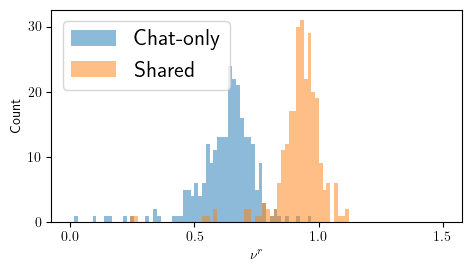

In [32]:
zoom = [0, 1.5]
reconstruction_ratio = chat_only_df["beta_ratio_reconstruction"]
reconstruction_ratio_shared = shared_df["beta_ratio_reconstruction"]

# Filter out nans
reconstruction_ratio_filtered = reconstruction_ratio[~np.isnan(reconstruction_ratio) ]
reconstruction_ratio_shared_filtered = reconstruction_ratio_shared[~np.isnan(reconstruction_ratio_shared) ]

# Compute combined range for consistent bins
all_data = np.concatenate([
    reconstruction_ratio_filtered,
    reconstruction_ratio_shared_filtered, 
])
if zoom is None:
    min_val, max_val = np.min(all_data), np.max(all_data)
else:
    min_val, max_val = zoom[0], zoom[1]
bins = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(5, 3))
plt.rcParams['text.usetex'] = True
plt.hist(reconstruction_ratio_filtered, bins=bins, alpha=0.5, label='Chat-only')
plt.hist(reconstruction_ratio_shared_filtered, bins=bins, alpha=0.5, label='Shared')
# plt.hist(baseline_reconstruction_ratio_filtered, bins=bins, alpha=0.5, label='Baseline')
# plt.title("Reconstruction Ratios (Base/Chat)" + (f" (zoomed on {zoom})" if zoom is not None else ""))
plt.xlabel("$\\nu^r$")
plt.ylabel("Count")
# plt.yscale("log")
plt.rcParams.update({'font.size': 16})  # Increase font size for all text elements
plt.rcParams.update({'legend.fontsize': 16})  # Smaller font size just for legend

plt.legend()
plt.tight_layout()
plt.savefig(PLOTS / "reconstruction_ratio.pdf", bbox_inches='tight')
plt.show()

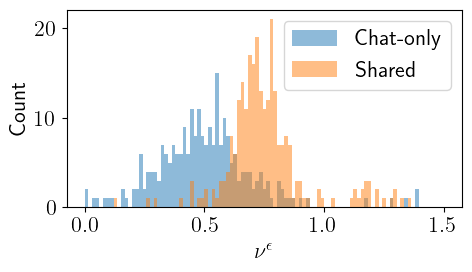

In [33]:
zoom = [0, 1.5]
error_ratio = chat_only_df["beta_ratio_error"]
error_ratio_shared = shared_df["beta_ratio_error"]

# Filter out nans
error_ratio_filtered = error_ratio[~np.isnan(error_ratio) ]
error_ratio_shared_filtered = error_ratio_shared[~np.isnan(error_ratio_shared) ]

# Compute combined range for consistent bins
all_data = np.concatenate([
    error_ratio_filtered,
    error_ratio_shared_filtered, 
])
if zoom is None:
    min_val, max_val = np.min(all_data), np.max(all_data)
else:
    min_val, max_val = zoom[0], zoom[1]
bins = np.linspace(min_val, max_val, 100)

plt.figure(figsize=(5, 3))
plt.rcParams['text.usetex'] = True
plt.hist(error_ratio_filtered, bins=bins, alpha=0.5, label='Chat-only')
plt.hist(error_ratio_shared_filtered, bins=bins, alpha=0.5, label='Shared')
# plt.hist(baseline_reconstruction_ratio_filtered, bins=bins, alpha=0.5, label='Baseline')
# plt.title("Reconstruction Ratios (Base/Chat)" + (f" (zoomed on {zoom})" if zoom is not None else ""))
plt.xlabel("$\\nu^\\epsilon$")
plt.ylabel("Count")
# plt.yscale("log")
plt.rcParams.update({'font.size': 16})  # Increase font size for all text elements
plt.rcParams.update({'legend.fontsize': 16})  # Smaller font size just for legend

plt.legend()
plt.tight_layout()
plt.savefig(PLOTS / "error_ratio.pdf", bbox_inches='tight')
plt.show()

In [8]:
PLOTS

PosixPath('/workspace/data/plots')

In [1]:
# zoom = [0, 1.1]
# Create figure with a main plot and two side histograms
fig = plt.figure(figsize=(13, 3))

# Create a grid of subplots with different widths/heights
# Increase right margin to accommodate colorbar
gs = plt.GridSpec(2, 2, width_ratios=[6, 1], height_ratios=[1, 4],
                  left=0.1, right=0.85, bottom=0.1, top=0.9,
                  wspace=0.01, hspace=0.05)

# Create the three axes
ax_scatter = fig.add_subplot(gs[1,0])  # Main plot
ax_histx = fig.add_subplot(gs[0,0], sharex=ax_scatter)  # x-axis histogram
ax_histy = fig.add_subplot(gs[1,1], sharey=ax_scatter)  # y-axis histogram

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})

# Filter out nans from both ratios simultaneously
valid_mask = ~(np.isnan(error_ratio) | np.isnan(reconstruction_ratio))
error_ratio_valid = error_ratio[valid_mask]
reconstruction_ratio_valid = reconstruction_ratio[valid_mask]

valid_mask_shared = ~(np.isnan(error_ratio_shared) | np.isnan(reconstruction_ratio_shared))
error_ratio_shared_valid = error_ratio_shared[valid_mask_shared]
reconstruction_ratio_shared_valid = reconstruction_ratio_shared[valid_mask_shared]

# Apply zoom mask to both datasets
zoom_mask = (error_ratio_valid>zoom[0]) & (error_ratio_valid<zoom[1]) & (reconstruction_ratio_valid>zoom[0]) & (reconstruction_ratio_valid<zoom[1])
error_ratio_zoomed = error_ratio_valid[zoom_mask]
reconstruction_ratio_zoomed = reconstruction_ratio_valid[zoom_mask]

zoom_mask_shared = (error_ratio_shared_valid>zoom[0]) & (error_ratio_shared_valid<zoom[1]) & (reconstruction_ratio_shared_valid>zoom[0]) & (reconstruction_ratio_shared_valid<zoom[1])
error_ratio_shared_zoomed = error_ratio_shared_valid[zoom_mask_shared]
reconstruction_ratio_shared_zoomed = reconstruction_ratio_shared_valid[zoom_mask_shared]


# Plot the scatter plots with swapped axes
ax_scatter.scatter(reconstruction_ratio_zoomed, error_ratio_zoomed,
                  alpha=0.2, label='Chat-only', s=5)
ax_scatter.scatter(reconstruction_ratio_shared_zoomed, error_ratio_shared_zoomed,
                  alpha=0.2, label='Shared', s=5)

# Plot the histograms with swapped axes
bins = 50
ax_histx.hist(reconstruction_ratio_zoomed, bins=bins, range=zoom, alpha=0.5, label='Chat-only')
ax_histx.hist(reconstruction_ratio_shared_zoomed, bins=bins, range=zoom, alpha=0.5, label='Shared')
ax_histy.hist(error_ratio_zoomed, bins=bins, range=zoom, 
              orientation='horizontal', alpha=0.5)
ax_histy.hist(error_ratio_shared_zoomed, bins=bins, range=zoom,
              orientation='horizontal', alpha=0.5)

# Turn off tick labels on histograms
ax_histx.tick_params(labelbottom=False, bottom=False)
ax_histy.tick_params(labelleft=False, left=False)

# Add labels with swapped axes
ax_scatter.set_xlabel("$\\nu^r$")
ax_scatter.set_ylabel("$\\nu^\\epsilon$")

# Add legend to top histogram with larger points
# Move legend below the plot
ax_histx.legend(fontsize=14, markerscale=4, loc='lower right', bbox_to_anchor=(1.0, -4.2))

plt.savefig(plots_dir / "error_vs_reconstruction_ratio_everything.pdf", bbox_inches='tight')
plt.show()


NameError: name 'plt' is not defined

In [35]:
# Create histogram of beta_ratio_error for latents with lmsys_ctrl_% > 0.05
filtered_df = chat_only_df[(chat_only_df["lmsys_ctrl_%"] > 0.3)]
twin_df = chat_only_df[(chat_only_df["twin_latent"] != -1)]

plt.figure(figsize=(6, 4))

low = -0.1
high = 1.1

plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})

filtered_df["beta_ratio_error"].hist(bins=50, range=(low, high))
# Plot full distribution
chat_only_df["beta_ratio_error"].hist(bins=50, range=(low, high), alpha=0.5, color='lightgray', label='All chat-only latents')
# Plot filtered distribution on top
filtered_df["beta_ratio_error"].hist(bins=50, range=(low, high), alpha=0.7, color='blue', label='High Template Perc.')
# Plot twin distribution
twin_df["beta_ratio_error"].hist(bins=50, range=(low, high), alpha=0.7, color='red', label='Twin Latents')
plt.legend()

# percentage of activations of template tokens

# plt.title("Distribution of $\\nu^\\epsilon$ for chat-only latents with a high percentage of activation on template tokens.")
plt.xlabel("$\\nu^\\epsilon$")
plt.ylabel("Count")
plt.show()
plt.savefig(PLOTS / "special_groups_beta_ratio_error.pdf", bbox_inches='tight')

KeyError: 'lmsys_ctrl_%'

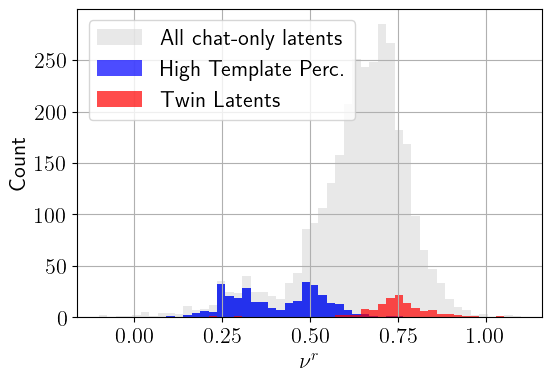

<Figure size 640x480 with 0 Axes>

In [142]:
# Create histogram of beta_ratio_error for latents with lmsys_ctrl_% > 0.05
filtered_df = chat_only_df[(chat_only_df["lmsys_ctrl_%"] > 0.3)]
twin_df = chat_only_df[(chat_only_df["twin_latent"] != -1)]

low = -0.1
high = 1.1

plt.figure(figsize=(6, 4))
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})

filtered_df["beta_ratio_reconstruction"].hist(bins=50, range=(low, high))
# Plot full distribution
chat_only_df["beta_ratio_reconstruction"].hist(bins=50, range=(low, high), alpha=0.5, color='lightgray', label='All chat-only latents')
# Plot filtered distribution on top
filtered_df["beta_ratio_reconstruction"].hist(bins=50, range=(low, high), alpha=0.7, color='blue', label='High Template Perc.')

# Plot twin distribution
twin_df["beta_ratio_reconstruction"].hist(bins=50, range=(low, high), alpha=0.7, color='red', label='Twin Latents')
plt.legend()

# percentage of activations of template tokens

# plt.title("Distribution of $\\\nu^r$ for chat-only latents with a high percentage of activation on template tokens.")
plt.xlabel("$\\nu^r$")
plt.ylabel("Count")
plt.show()
plt.savefig(PLOTS / "special_groups_beta_ratio_reconstruction.pdf", bbox_inches='tight')

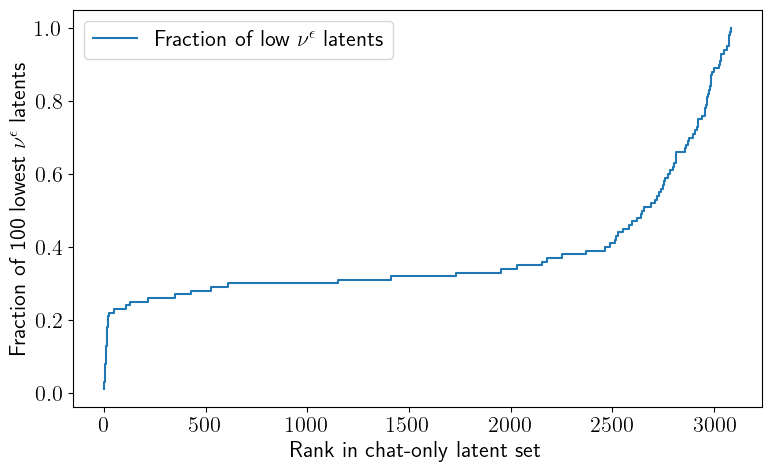

<Figure size 640x480 with 0 Axes>

In [144]:
# Get ranks of low nu_error latents
low_nu_error_indices = chat_only_df["beta_ratio_error"].sort_values(ascending=True).index[:100]
all_latent_ranks = chat_only_df["dec_norm_diff"].rank()
low_nu_error_ranks = all_latent_ranks[low_nu_error_indices].sort_values()

# Calculate fractions
total_low_nu_error_latents = len(low_nu_error_indices)
fractions = np.arange(1, len(low_nu_error_ranks) + 1) / total_low_nu_error_latents

# Create figure
plt.figure(figsize=(8, 5))
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
# Plot step function
plt.step(low_nu_error_ranks, fractions, where='post', label='Fraction of low $\\nu^\\epsilon$ latents')

# Update layout
plt.xlabel("Rank in chat-only latent set")
plt.ylabel("Fraction of 100 lowest $\\nu^\\epsilon$ latents")
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig(PLOTS / "low_nu_error_latents_rank_distribution.pdf", bbox_inches='tight')

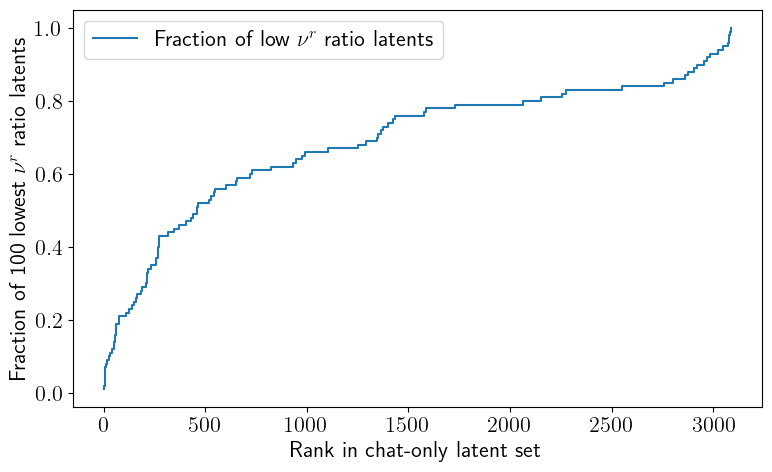

<Figure size 640x480 with 0 Axes>

In [145]:
# Get ranks of high beta ratio latents
low_nu_r_indices = chat_only_df["beta_ratio_reconstruction"].sort_values(ascending=True).index[:100]
all_latent_ranks = chat_only_df["dec_norm_diff"].rank()
low_nu_r_ranks = all_latent_ranks[low_nu_r_indices].sort_values()

# Calculate fractions
total_low_nu_r_latents = len(low_nu_r_indices)
fractions = np.arange(1, len(low_nu_r_ranks) + 1) / total_low_nu_r_latents

# Create figure
plt.figure(figsize=(8, 5))
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})
# Plot step function
plt.step(low_nu_r_ranks, fractions, where='post', label='Fraction of low $\\nu^r$ ratio latents')

# Update layout
plt.xlabel("Rank in chat-only latent set")
plt.ylabel("Fraction of 100 lowest $\\nu^r$ ratio latents")
plt.legend()

plt.tight_layout()
plt.show()
plt.savefig(PLOTS / "low_nu_r_latents_rank_distribution.pdf", bbox_inches='tight')

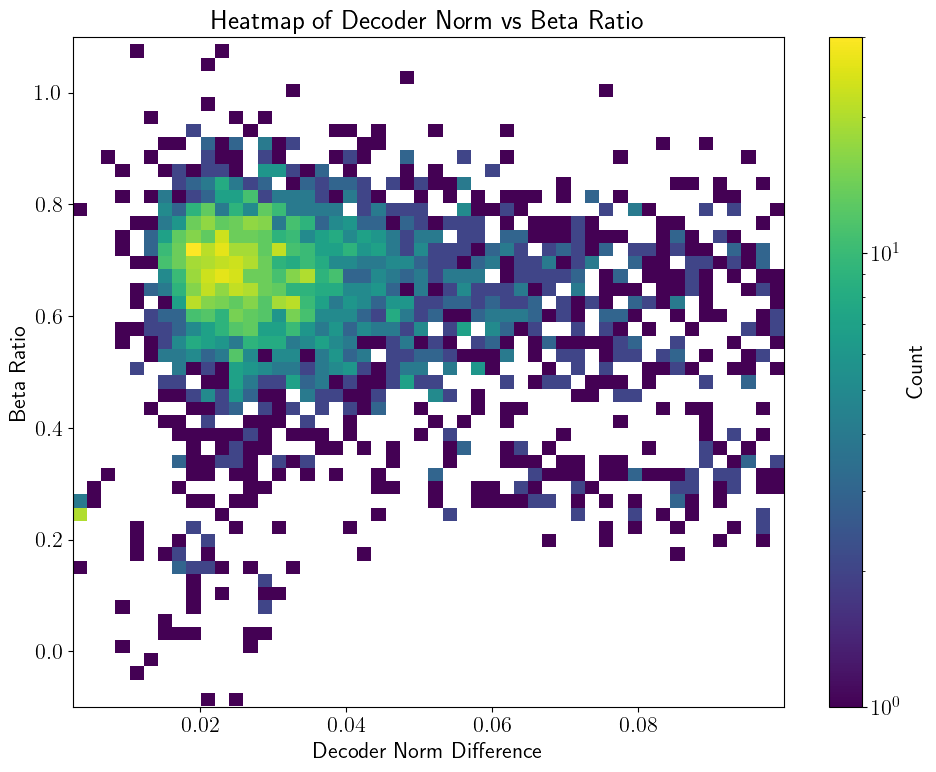

<Figure size 640x480 with 0 Axes>

In [146]:
# Create data for heatmap
x = chat_only_df["dec_norm_diff"]
y = chat_only_df["beta_ratio_reconstruction"]

# Remove NaN values and limit beta ratio range
mask = ~(np.isnan(x) | np.isnan(y))
x = x[mask]
y = y[mask]

# Apply beta ratio limits
mask_limits = (y >= -0.1) & (y <= 1.1)
x = x[mask_limits]
y = y[mask_limits]

# Create 2D histogram
plt.figure(figsize=(10, 8))
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})

# Plot heatmap using hist2d
plt.hist2d(x, y, bins=50, cmap='viridis', norm='log')
plt.colorbar(label='Count')

# Update layout
plt.xlabel("Decoder Norm Difference")
plt.ylabel("Beta Ratio")
plt.title("Heatmap of Decoder Norm vs Beta Ratio")

# Set y-axis limits
plt.ylim(-0.1, 1.1)

plt.tight_layout()
plt.show()
plt.savefig(PLOTS / "dec_norm_beta_ratio_heatmap.pdf", bbox_inches='tight')

# Statistical Analysis

In [18]:
import numpy as np
from scipy import stats
from scipy.integrate import quad
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy.stats as st

# baseline_ratio = betas["baselines"]["base"]["reconstruction"] / betas["normal"]["it"]["reconstruction"]
# measurement_ratio = betas["normal"]["base"]["reconstruction"] / betas["normal"]["it"]["reconstruction"]

# nan_mask = th.isnan(baseline_ratio) | th.isnan(measurement_ratio)
# baseline_ratio = baseline_ratio[~nan_mask].numpy()
# measurement_ratio = measurement_ratio[~nan_mask].numpy()

def calculate_z_scores(baseline, comparison):
    # Calculate baseline statistics
    baseline_mean = np.mean(baseline)
    baseline_std = np.std(baseline)
    # Calculate z-scores for comparison values
    z_scores = (comparison - baseline_mean) / baseline_std

    return z_scores

def normalProbabilityDensity(x):
    constant = 1.0 / np.sqrt(2*np.pi)
    return(constant * np.exp((-x**2) / 2.0) )

z_scores = calculate_z_scores(shared_df["beta_ratio_reconstruction"], chat_only_df["beta_ratio_reconstruction"])
# Get confidence interval
confidence_level = 0.5
upper_score = (1+confidence_level)/2
upper_limit = st.norm.ppf(upper_score)
lower_score = (1-confidence_level)/2
lower_limit = st.norm.ppf(lower_score)
print(upper_score, lower_score)
same_as_shared_mask = (z_scores > lower_limit) & (z_scores < upper_limit)

0.75 0.25


In [19]:
print(f"Number of chat-only indices in shared 95% confidence interval: {same_as_shared_mask.sum()}")
print(f"Total number of chat-only indices: {len(same_as_shared_mask)}")
print(f"Percentage: {100 * same_as_shared_mask.sum() / len(same_as_shared_mask):.1f}%")

Number of chat-only indices in shared 95% confidence interval: 3
Total number of chat-only indices: 265
Percentage: 1.1%


In [17]:
print(f"Number of chat-only indices in shared 50% confidence interval: {same_as_shared_mask.sum()}")
print(f"Total number of chat-only indices: {len(same_as_shared_mask)}")
print(f"Percentage: {100 * same_as_shared_mask.sum() / len(same_as_shared_mask):.1f}%")

Number of chat-only indices in shared 50% confidence interval: 47
Total number of chat-only indices: 265
Percentage: 17.7%


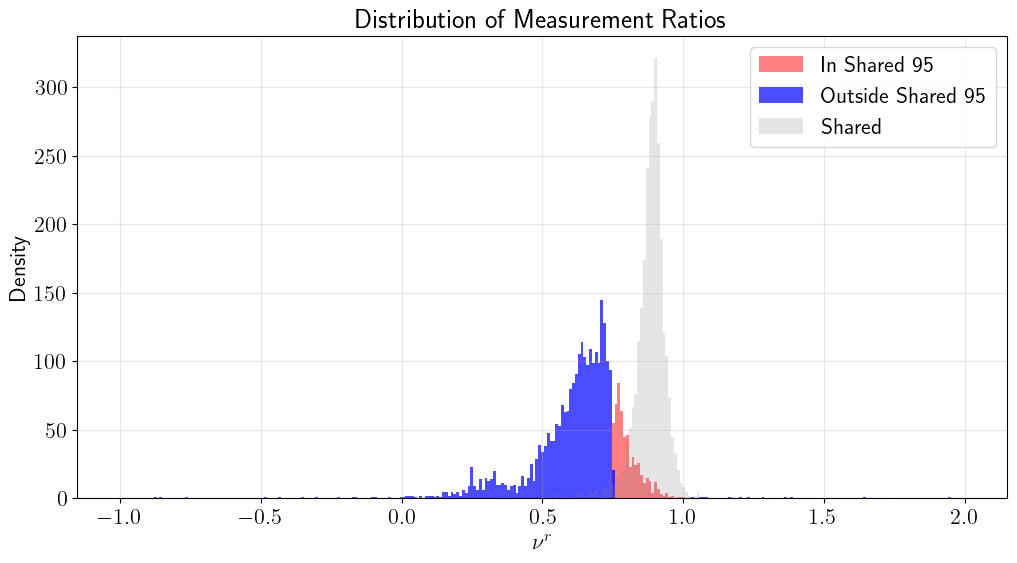

In [140]:
plt.figure(figsize=(12, 6))
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 16})

bins = np.linspace(-1, 2, 300)

# Plot histograms
plt.hist(reconstruction_ratio_filtered[same_as_shared_mask], bins=bins, alpha=0.5, color='red', label=f'In Shared 95% confidence interval')
plt.hist(reconstruction_ratio_filtered[~same_as_shared_mask], bins=bins, alpha=0.7, color='blue', label=f'Outside Shared 95% confidence interval')

plt.hist(reconstruction_ratio_shared_filtered, bins=bins, alpha=0.2, label='Shared', color='gray')
plt.xlabel('$\\nu^r$')
plt.ylabel('Count')
plt.title('Distribution of $\\nu^r$')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
def analyze_with_z_scores(baseline_ratio, measurement_ratio, confidence_level=0.95):
    # Calculate z-scores
    baseline_mean = np.mean(baseline_ratio)
    baseline_std = np.std(baseline_ratio)
    z_scores = (measurement_ratio - baseline_mean) / baseline_std
    
    # Get critical values for the confidence interval
    critical_value = st.norm.ppf((1 + confidence_level) / 2)
    
    # Identify measurements that fall outside the confidence interval
    significant_mask = np.abs(z_scores) > critical_value
    
    # Calculate percentages
    pct_significant = 100 * np.mean(significant_mask)
    pct_above = 100 * np.mean(z_scores > critical_value)
    pct_below = 100 * np.mean(z_scores < -critical_value)
    
    return {
        'z_scores': z_scores,
        'significant_mask': significant_mask,
        'pct_significant': pct_significant,
        'pct_above': pct_above,
        'pct_below': pct_below,
        'critical_value': critical_value
    }

# Analyze the data
results = analyze_with_z_scores(reconstruction_ratio_shared_filtered, reconstruction_ratio_filtered)

# Visualization
plt.figure(figsize=(12, 6))

# Plot histograms
bins = np.linspace(-1, 2, 300)
plt.hist(reconstruction_ratio_filtered[~results['significant_mask']], 
         bins=bins, alpha=0.5, color='blue', 
         label='Within Shared 95% confidence interval')
plt.hist(reconstruction_ratio_filtered[results['significant_mask']], 
         bins=bins, alpha=0.5, color='red',
         label='Significantly different')
plt.hist(reconstruction_ratio_shared_filtered, bins=bins, alpha=0.2, 
         label='Shared', color='gray')

plt.xlabel('Ratio Values')
plt.ylabel('Count')
plt.title(f'Distribution of Ratios\n'
          f'{results["pct_significant"]:.1f}% significantly different from baseline\n'
          f'({results["pct_above"]:.1f}% above, {results["pct_below"]:.1f}% below)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
baseline_ratio_filtered = betas["baselines"]["base"]["reconstruction"] / betas["normal"]["it"]["reconstruction"]
measurement_ratio_filtered = betas["normal"]["base"]["reconstruction"] / betas["normal"]["it"]["reconstruction"]

nan_mask = th.isnan(baseline_ratio_filtered) | th.isnan(measurement_ratio_filtered)
baseline_ratio_filtered = baseline_ratio_filtered[~nan_mask].numpy()
measurement_ratio_filtered = measurement_ratio_filtered[~nan_mask].numpy()
thres = count_active["baselines"]["base"]["reconstruction"][~nan_mask].quantile(0.01)
print(thres)
baseline_ratio_filtered = baseline_ratio_filtered[count_active["baselines"]["base"]["reconstruction"][~nan_mask]>thres]
measurement_ratio_filtered = measurement_ratio_filtered[count_active["normal"]["base"]["reconstruction"][~nan_mask]>thres]

In [ ]:
plt.figure(figsize=(12,6))
plt.hist(z_scores, bins=100, density=True, alpha=0.7, color='blue', range=(-1, 1))
plt.xlabel('Z-Score')
plt.ylabel('Density')
plt.title('Distribution of Z-Scores')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

plt.figure(figsize=(12,6))
plt.hist(percentiles, bins=100, density=True, alpha=0.7, color='blue', range=(-1, 1))
plt.xlabel('Percentile under standard normal')
plt.ylabel('Density')
plt.title('Distribution of percentiles')

plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:

def compute_likelihood_under_baseline(baseline, comparison, bandwidth=None, normalize=True):
    """
    Computes the likelihood of each sample in comparison under the baseline distribution.
    Uses kernel density estimation to approximate the baseline distribution.
    
    Args:
        baseline (array-like): Baseline samples used to estimate the distribution
        comparison (array-like): Samples to evaluate likelihood for
        bandwidth (float): Bandwidth parameter for kernel density estimation
        
    Returns:
        array-like: Log likelihood for each comparison sample
    """

    # Fit KDE to baseline distribution
    kde = stats.gaussian_kde(baseline, bw_method=bandwidth)
    
    # Compute pdf of comparison samples
    pdf = kde.pdf(comparison)

    if normalize:
        # Normalize to [0,1] range
        pdf = pdf / pdf.max()
        
    return pdf

likelihood = compute_likelihood_under_baseline(baseline_ratio, measurement_ratio, normalize=True)

plt.figure(figsize=(12, 6))
plt.hist(likelihood, bins=50, density=True)
plt.xlabel('Likelihood')
plt.ylabel('Density')
plt.title('Distribution of Likelihoods under Baseline Model')
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
plt.figure(figsize=(12, 6))

threshold = 0.4

# Get indices where likelihood is below 0.4
low_likelihood_mask = likelihood < threshold

bins = np.linspace(-1, 2, 300)

# Plot histograms
plt.hist(reconstruction_ratio_filtered[~low_likelihood_mask], bins=bins, alpha=0.5, color='blue', label='Normal Measurements')
plt.hist(reconstruction_ratio_filtered[low_likelihood_mask], bins=bins, alpha=0.7, color='red', label=f'Likelihood under baseline < {threshold}')

plt.hist(reconstruction_ratio_shared_filtered, bins=bins, alpha=0.2, label='Shared', color='gray')
plt.xlabel('Ratio Values')
plt.ylabel('Density')
plt.title('Distribution of Measurement Ratios')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
measurement_ratio.shape, likelihood.shape, measurement_ratio.shape

In [ ]:
import matplotlib.pyplot as plt

# Create figure and axis
plt.figure(figsize=(12, 6))
zoom = [-1, 2]
# Plot histograms
plt.hist(baseline_ratio.numpy(), bins=100, alpha=0.5, label='Baseline Ratio', density=True, range=zoom)
plt.hist(measurement_ratio.numpy(), bins=100, alpha=0.5, label='Measurement Ratio', density=True, range=zoom)

# Highlight significant values
plt.hist(significant_values, bins=100, alpha=0.7, color='red', label='Significant Values', density=True, range=zoom)

plt.xlabel('Ratio Values')
plt.ylabel('Density')
plt.title('Distribution of Ratios with Significant Values Highlighted')
plt.legend()

# Add vertical line at mean of baseline
plt.axvline(x=np.mean(baseline_ratio.numpy()), color='k', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()


In [55]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

def analyze_distributions(baseline, comparison, alpha=0.05):
    nan_mask = th.isnan(baseline) | th.isnan(comparison)
    baseline = baseline[~nan_mask].numpy()
    comparison = comparison[~nan_mask].numpy()
    zoom = [-1, 2]
    # Perform KS test
    ks_statistic, p_value = stats.ks_2samp(baseline, comparison)
    
    # Calculate basic statistics
    baseline_mean = np.mean(baseline)
    baseline_std = np.std(baseline)
    comparison_mean = np.mean(comparison)
    comparison_std = np.std(comparison)
    
    # Create visualization
    plt.figure(figsize=(12, 6))
    
    # Plot histograms
    plt.hist(baseline, bins=30, alpha=0.5, label='Baseline', density=True)
    plt.hist(comparison, bins=30, alpha=0.5, label='Comparison', density=True)
    
    # Plot CDFs (Cumulative Distribution Functions)
    baseline_sorted = np.sort(baseline)
    comparison_sorted = np.sort(comparison)
    plt.step(baseline_sorted, np.arange(1, len(baseline) + 1) / len(baseline), 
             'b--', alpha=0.5, label='Baseline CDF')
    plt.step(comparison_sorted, np.arange(1, len(comparison) + 1) / len(comparison), 
             'r--', alpha=0.5, label='Comparison CDF')
    
    plt.legend()
    plt.title('Distribution Comparison with KS Test')
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.xlim(zoom)
    
    # Print results
    print(f"KS Test Results:")
    print(f"Statistic: {ks_statistic:.4f}")
    print(f"P-value: {p_value:.4f}")
    print(f"\nDistribution Statistics:")
    print(f"Baseline - Mean: {baseline_mean:.4f}, Std: {baseline_std:.4f}")
    print(f"Comparison - Mean: {comparison_mean:.4f}, Std: {comparison_std:.4f}")
    
    # Interpret results
    print("\nInterpretation:")
    if p_value < alpha:
        print(f"The distributions are significantly different (p < {alpha})")
    else:
        print(f"Cannot reject the null hypothesis that the distributions are the same (p >= {alpha})")
    
    return ks_statistic, p_value

In [ ]:

ks_statistic, p_value = analyze_distributions(baseline_ratio, measurement_ratio)
ks_statistic, p_value


In [65]:
def find_optimal_threshold(baseline, comparison):
    # Combine and sort all values
    all_values = np.sort(np.concatenate([baseline, comparison]))
    
    best_threshold = None
    best_separation = -np.inf
    
    for threshold in all_values:  # Sample every 10th point for efficiency
        # Calculate separation metric
        true_positive_rate = np.mean(comparison > threshold)
        false_positive_rate = np.mean(baseline > threshold)
        
        # Use Youden's J statistic
        separation = true_positive_rate - false_positive_rate
        
        if separation > best_separation:
            best_separation = separation
            best_threshold = threshold
    
    return best_threshold, best_separation

# Visualization of the results
def plot_threshold_analysis(baseline, comparison, threshold, zoom=[-1, 2]):
    plt.figure(figsize=(12, 6))
    
    # Plot histograms
    plt.hist(baseline, bins=50, alpha=0.5, density=True, label='Baseline', range=zoom)
    plt.hist(comparison, bins=50, alpha=0.5, density=True, label='Comparison', range=zoom)
    
    # Plot threshold line
    plt.axvline(x=threshold, color='r', linestyle='--', 
                label=f'Threshold = {threshold:.3f}')
    
    # Calculate percentages above threshold
    baseline_above = 100 * np.mean(baseline > threshold)
    comparison_above = 100 * np.mean(comparison > threshold)
    
    plt.title(f'Distribution Comparison with Threshold\n' +
              f'Baseline above: {baseline_above:.1f}%, ' +
              f'Comparison above: {comparison_above:.1f}%')
    plt.legend()
    plt.xlabel('Value')
    plt.ylabel('Density')
    plt.show()

In [61]:
non_nan_mask = ~th.isnan(baseline_ratio) & ~th.isnan(measurement_ratio)
baseline_ratio = baseline_ratio[non_nan_mask].numpy()
measurement_ratio = measurement_ratio[non_nan_mask].numpy()


In [ ]:
# Find optimal threshold
threshold, separation = find_optimal_threshold(baseline_ratio, measurement_ratio)
print(f"Optimal threshold: {threshold:.3f}")
print(f"Separation score: {separation:.3f}")

# Visualize results
plot_threshold_analysis(baseline_ratio, measurement_ratio, threshold)

In [ ]:
fig = plot_scaler_histograms(betas, "error", title="Scaler Histogram Analysis for Error", xpos_legend=0.08, xpos_inset=0.72)
fig.add_annotation(
    x=-2,
    y=100,
    ax=-170,
    ay=-80,
    xref="x3",
    yref="y3",
    text="",
    showarrow=True,
    arrowhead=2,
)
fig.write_image(PLOTS / "error_ratio.png")
fig.show()

In [ ]:
betas["normal"]["base"]["error"]

In [ ]:
df["lmsys_ctrl_freq"].hist(bins=100)

In [ ]:
C_0_latents = df[df["tag"] == "IT only"]
C_0_latents

In [ ]:
C_0_latents.sort_values(by="beta_ratio_error", key=abs).head(20).index


In [ ]:
# Sort by absolute beta ratio error and get 20 lowest
C_0_latents.sort_values(by="beta_ratio_error", key=abs).head(100)["lmsys_ctrl_%"].hist(bins=50)
plt.title("Distribution of lmsys_ctrl_% for Latents with Low Beta Ratio Error")
plt.xlabel("lmsys_ctrl_%")
plt.ylabel("Count")
plt.show()

In [ ]:
# Sort by absolute beta ratio error and get 20 lowest
C_0_latents.sort_values(by="beta_ratio_error", key=abs)["lmsys_ctrl_%"].hist(bins=50)
plt.title("Distribution of lmsys_ctrl_% for Latents with Low Beta Ratio Error")
plt.xlabel("lmsys_ctrl_%")
plt.ylabel("Count")
plt.show()

In [56]:
# Get C_S latents (those with very small beta ratio error)
C_S_latents = df[df["beta_ratio_error"].abs() < 0.1]
C_S_indices = C_S_latents.index.to_numpy()


In [ ]:
# Get ranks of C_1 latents based on dec_norm_diff in full set
all_latent_ranks = df.loc[latent_indices, "dec_norm_diff"].rank()
C_S_ranks = all_latent_ranks[C_S_indices].sort_values()

# Calculate fractions
total_C_S_latents = len(C_S_indices)
fractions = np.arange(1, len(C_S_ranks) + 1) / total_C_S_latents

# Create figure
fig = go.Figure()

# Add scatter plot with step shape
fig.add_trace(go.Scatter(
    x=C1_ranks,
    y=fractions,
    mode='lines',
    name='Fraction of C_S Latents',
    line=dict(shape='hv')  # Use 'hv' for horizontal-vertical steps
))

# Update layout
fig.update_layout(
    title="Distribution of C_S Latents by Rank",
    xaxis_title="Rank in C_0 Latent Set", 
    yaxis_title="Fraction of C_S Latents",
    width=800,
    height=500
)
fig.show()
fig.write_image(plots_dir / "C_S_latents_rank_distribution.png")

In [ ]:
# Get C_R latents (those with very small beta ratio reconstruction)
C_R_latents = df[df["beta_ratio_reconstruction"].abs() < 0.1]
C_R_indices = C_R_latents.index.to_numpy()
C_R_indices

In [ ]:
# Get ranks of C_1 latents based on dec_norm_diff in full set
all_latent_ranks = df.loc[latent_indices, "dec_norm_diff"].rank()
C_R_ranks = all_latent_ranks[C_R_indices].sort_values()

# Calculate fractions
total_C_R_latents = len(C_R_indices)
fractions = np.arange(1, len(C_R_ranks) + 1) / total_C_R_latents

# Create figure
fig = go.Figure()

# Add scatter plot with step shape
fig.add_trace(go.Scatter(
    x=C_R_ranks,
    y=fractions,
    mode='lines',
    name='Fraction of C_R Latents',
    line=dict(shape='hv')  # Use 'hv' for horizontal-vertical steps
))

# Update layout
fig.update_layout(
    title="Distribution of C_R Latents by Rank",
    xaxis_title="Rank in C_0 Latent Set", 
    yaxis_title="Fraction of C_R Latents",
    width=800,
    height=500
)
fig.show()
fig.write_image(plots_dir / "C_R_latents_rank_distribution.png")

In [ ]:
# Get ranks of C_1 latents based on beta ratio reconstruction in full set
all_latent_ranks = df.loc[latent_indices, "beta_ratio_reconstruction"].rank()
C_S_ranks = all_latent_ranks[C_S_indices].sort_values()

# Calculate fractions
total_C_S_latents = len(C_S_indices)
fractions = np.arange(1, len(C_S_ranks) + 1) / total_C_S_latents

# Create figure
fig = go.Figure()

# Add scatter plot with step shape
fig.add_trace(go.Scatter(
    x=C1_ranks,
    y=fractions,
    mode='lines',
    name='Fraction of C_S Latents',
    line=dict(shape='hv')  # Use 'hv' for horizontal-vertical steps
))

# Update layout
fig.update_layout(
    title="Distribution of C_S Latents by Beta Ratio Reconstruction Rank",
    xaxis_title="Rank in C_0 Latent Set", 
    yaxis_title="Fraction of C_S Latents",
    width=800,
    height=500
)
fig.show()
fig.write_image(plots_dir / "C_S_latents_beta_ratio_rank_distribution.png")

In [ ]:
# Plot heatmap between beta_ratio_error and beta_ratio_reconstruction
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Create 2D histogram
error_ratio = df["beta_ratio_error"]
reconstruction_ratio = df["beta_ratio_reconstruction"]
nans = np.isnan(error_ratio) | np.isnan(reconstruction_ratio)
error_ratio = error_ratio[~nans]
reconstruction_ratio = reconstruction_ratio[~nans]

h = ax.hist2d(
    error_ratio,
    reconstruction_ratio,
    bins=100,
    norm=LogNorm()
)

# Add colorbar
plt.colorbar(h[3], ax=ax)

# Update layout
ax.set_title(f"Beta Ratio Error vs Beta Ratio Reconstruction")
ax.set_xlabel("Beta Ratio Error")
ax.set_ylabel("Beta Ratio Reconstruction")

plt.tight_layout()
plt.savefig(PLOTS / "beta_ratio_error_vs_reconstruction.png")
plt.show()


In [ ]:
# Plot heatmap between beta_ratio_error and beta_ratio_reconstruction
import matplotlib.pyplot as plt

start = 0
end = 1
size = 0.01
bins = int((end - start) / size)

# Create figure and axis
fig, ax = plt.subplots(figsize=(8, 5))

# Create 2D histogram
h = ax.hist2d(
    df["beta_ratio_error"],
    df["beta_ratio_reconstruction"],
    bins=bins,
    range=[[start, end], [start, end]]
)

# Add colorbar
plt.colorbar(h[3], ax=ax)

# Update layout
ax.set_title(f"Beta Ratio Error vs Beta Ratio Reconstruction (zoomed, {start} to {end})")
ax.set_xlabel("Beta Ratio Error")
ax.set_ylabel("Beta Ratio Reconstruction")
ax.set_xlim(start, end)
ax.set_ylim(start, end)

plt.tight_layout()
plt.savefig(PLOTS / "beta_ratio_error_vs_reconstruction_zoomed.png")
plt.show()


In [ ]:
C_SR_latents = df[(df["beta_ratio_error"].abs() < 0.2) & (df["beta_ratio_reconstruction"].abs() < 0.2)]
C_SR_indices = C_SR_latents.index.to_numpy()
C_SR_indices


In [9]:
test_indices = [69810, 15338, 21760, 38337, 51823, 55432,57717,68066, 51408]
test_names = ["Code", "Code", "Model Refuses, User Persists", "Story, Scene or Poem", "Questions?", "Discuss, Explain, Describe", "up-to-date information", "model's capabilities", "Global Sensitivity"]

In [ ]:
# Plot beta ratio error and reconstruction for test indices
fig = go.Figure()

# Add scatter points for test indices
fig.add_trace(go.Scatter(
    x=df.loc[test_indices, "beta_ratio_error"],
    y=df.loc[test_indices, "beta_ratio_reconstruction"],
    mode='markers+text',
    marker=dict(
        size=10,
        color='red',
        symbol='x'
    ),
    text=[f'{i}' for i in test_names],
    textposition='top center',
    name='Test Points'
))

# Update layout
fig.update_layout(
    title="Beta Ratio Error vs Beta Ratio Reconstruction (Test Points)",
    xaxis_title="Beta Ratio Error",
    yaxis_title="Beta Ratio Reconstruction", 
    width=800,
    height=500
)

fig.show()
fig.write_image(PLOTS / "beta_ratio_error_vs_reconstruction_test_points.png")

In [ ]:

# Plot beta ratio error and reconstruction for test indices
fig = go.Figure()

# Add scatter points for test indices
fig.add_trace(go.Scatter(
    x=df.loc[test_indices, "beta_base_error"],
    y=df.loc[test_indices, "beta_chat_error"],
    mode='markers+text',
    marker=dict(
        size=10,
        color='red',
        symbol='x'
    ),
    text=[f'{i}' for i in test_names],
    textposition='top center',
    name='Test Points'
))

# Update layout
fig.update_layout(
    title="Beta Base Error vs Beta Chat Error (Test Points)",
    xaxis_title="Beta Base Error",
    yaxis_title="Beta Chat Error", 
    width=800,
    height=500
)

fig.show()
fig.write_image(plots_dir / "beta_base_error_vs_chat_error_test_points.png")

In [ ]:

# Plot beta ratio error and reconstruction for test indices
fig = go.Figure()

# Add scatter points for test indices
fig.add_trace(go.Scatter(
    x=df.loc[test_indices, "beta_base_error"],
    y=df.loc[test_indices, "beta_base_reconstruction"],
    mode='markers+text',
    marker=dict(
        size=10,
        color='red',
        symbol='x'
    ),
    text=[f'{i}' for i in test_names],
    textposition='top center',
    name='Test Points'
))

# Update layout
fig.update_layout(
    title="Beta Base Error vs Beta Base Reconstruction (Test Points)",
    xaxis_title="Beta Base Error",
    yaxis_title="Beta Base Reconstruction", 
    width=800,
    height=500
)

# Set axis ranges to -1 to 1
start = -2
fig.update_xaxes(range=[-1, 1])
fig.update_yaxes(range=[0, 4])


fig.show()
fig.write_image(plots_dir / "beta_base_error_vs_base_reconstruction_test_points.png")

#### High Scalers Investigation

In [ ]:
df

In [ ]:
error_base = betas["normal"]["base"]["error"].cpu().numpy()
it_norm = df["dec_instruct_norm"].iloc[latent_indices].to_numpy()

fig = go.Figure()
# Calculate outliers using IQR method
x_q1, x_q3 = np.percentile(error_base, [25, 75])
y_q1, y_q3 = np.percentile(it_norm, [25, 75])
x_iqr = x_q3 - x_q1
y_iqr = y_q3 - y_q1
x_outliers = (error_base < (x_q1 - 1.5 * x_iqr)) | (error_base > (x_q3 + 1.5 * x_iqr))
y_outliers = (it_norm < (y_q1 - 1.5 * y_iqr)) | (it_norm > (y_q3 + 1.5 * y_iqr))
outliers = x_outliers | y_outliers

# Add scatter points for outliers only
fig.add_trace(go.Scatter(
    x=error_base[outliers],
    y=it_norm[outliers], 
    mode='markers',
    showlegend=False,
    marker=dict(
        symbol='x',
        opacity=0.7,
        color='white',
        size=8,
        line=dict(width=1),
    )
))

# Add 2D histogram
fig.add_trace(go.Histogram2d(
    x=error_base,
    y=it_norm,
))

# Update layout
fig.update_layout(
    title="2D Histogram of Base Error vs IT Norm<br><sub>Outliers (>1.5 IQR) shown as x</sub>",
    xaxis_title="Base Error",
    yaxis_title="IT Norm", 
    xaxis=dict(ticks='', showgrid=False, zeroline=False),
    yaxis=dict(ticks='', showgrid=False, zeroline=False),
    width=800,
    height=600,
    hovermode='closest'
)

fig.show()
fig.write_image(plots_dir / "C_S_latents_base_error_vs_it_norm.png")

### Qualitative Analysis

Use dashboard to get interpretability information

In [93]:
interpretability_information = {}

### Stats

In [96]:
from tools.utils import CCLatent

In [ ]:
stats_error = th.load("/workspace/data/results/closed_form_scalars/Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04/stats_base_error_.pt")
stats_reconstruction = th.load("/workspace/data/results/closed_form_scalars/Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04/stats_base_reconstruction_.pt")

In [ ]:
stats_error = th.load("/workspace/data/results/closed_form_scalars/Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04/stats_base_error_.pt")
stats_reconstruction = th.load("/workspace/data/results/closed_form_scalars/Butanium_gemma-2-2b-crosscoder-l13-mu4.1e-02-lr1e-04/stats_base_reconstruction_.pt")

In [ ]:
stats_error["mse"], stats_error["mse_before"]

In [ ]:

plt.figure(figsize=(10,5))
plt.hist(stats_error["mse"][-1, :], bins=100)
plt.title("MSE Buckets for Error")
plt.xlabel("MSE")
plt.ylabel("Count")
plt.show()


In [ ]:
SAME_Y = True
mse_buckets = stats_error["mse_buckets"]
mse_buckets_before = stats_error["mse_before_buckets"]
perc_improvement = (mse_buckets - mse_buckets_before) / mse_buckets_before 

# Create histogram of differences between MSE buckets
plt.figure(figsize=(15, 5))
plt.suptitle("MSE Percentage Improvement by Activation Bucket")

# Get max count across all buckets for consistent y-axis
max_count = 0
for i in range(4):
    counts, _ = np.histogram(perc_improvement[i][~np.isnan(perc_improvement[i])], bins=100)
    max_count = max(max_count, counts.max())

bucket_labels = ["0-5%", "5-33%", "33-66%", "66-100%"]
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.hist(perc_improvement[i][~np.isnan(perc_improvement[i])], bins=100)
    plt.title(f"Bucket {bucket_labels[i]}")
    plt.xlabel("Percentage Improvement")
    plt.ylabel("Count")
    if SAME_Y:
        plt.ylim(0, max_count*1.1)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
max_idx = np.nanargmax(perc_improvement[-1])
max_idx

In [ ]:
from tools.utils import offline_dashboard
offline_dashboard().display()

In [ ]:
CCLatent(latent_indices[max_idx]).stats

In [ ]:
for k in k:
    if "max" in k:
        print(k)
        print(CCLatent(latent_indices[max_idx]).stats[k])

In [ ]:
SAME_Y = True
mse_buckets = stats_error["mse_buckets"]
mse_buckets_before = stats_error["mse_before_buckets"]
perc_improvement = (mse_buckets - mse_buckets_before) / mse_buckets_before 

# Create histogram of differences between MSE buckets
plt.figure(figsize=(15, 5))
plt.suptitle("MSE Percentage Improvement by Activation Bucket (only negative values)")

# Calculate and print percentage of negative improvements per bucket
print("Percentage of features with negative improvement per bucket:")
for i, label in enumerate(bucket_labels):
    total_values = perc_improvement[i].shape[0]
    nan_count = np.isnan(perc_improvement[i]).sum()
    neg_values = perc_improvement[i][(~np.isnan(perc_improvement[i])) & (perc_improvement[i] < 0)]
    pct_negative = (len(neg_values) / total_values) * 100
    print(f"{label}: ")
    print(f"\t Nan: {nan_count/total_values*100:.2f}%")
    print(f"\t Negative: {pct_negative:.2f}%")
print()


# Get max count across all buckets for consistent y-axis
max_count = 0
for i in range(4):
    neg_values = perc_improvement[i][(~np.isnan(perc_improvement[i])) & (perc_improvement[i] < 0)]
    counts, _ = np.histogram(neg_values, bins=100)
    max_count = max(max_count, counts.max())

bucket_labels = ["0-5%", "5-33%", "33-66%", "66-100%"]
for i in range(4):
    plt.subplot(1, 4, i+1)
    neg_values = perc_improvement[i][(~np.isnan(perc_improvement[i])) & (perc_improvement[i] < 0)]
    plt.hist(neg_values, bins=100)
    plt.title(f"Bucket {bucket_labels[i]}")
    plt.xlabel("Percentage Improvement")
    plt.ylabel("Count")
    if SAME_Y:
        plt.ylim(0, max_count*1.1)

plt.tight_layout()
plt.show()


In [ ]:
SAME_Y = True
mse_buckets = stats_error["mse_buckets"]
mse_buckets_before = stats_error["mse_before_buckets"]
perc_improvement = (mse_buckets - mse_buckets_before) / mse_buckets_before 

# Create histogram of differences between MSE buckets
plt.figure(figsize=(15, 5))
plt.suptitle("MSE Percentage Improvement by Activation Bucket (only negative values)")

# Calculate and print percentage of negative improvements per bucket
print("Percentage of features with negative improvement per bucket:")
for i, label in enumerate(bucket_labels):
    total_values = perc_improvement[i].shape[0]
    nan_count = np.isnan(perc_improvement[i]).sum()
    neg_values = perc_improvement[i][(~np.isnan(perc_improvement[i])) & (perc_improvement[i] < 0)]
    pct_negative = (len(neg_values) / total_values) * 100
    print(f"{label}: ")
    print(f"\t Nan: {nan_count/total_values*100:.2f}%")
    print(f"\t Negative: {pct_negative:.2f}%")
print()


# Get max count across all buckets for consistent y-axis
max_count = 0
for i in range(4):
    neg_values = perc_improvement[i][(~np.isnan(perc_improvement[i])) & (perc_improvement[i] < 0)]
    counts, _ = np.histogram(neg_values, bins=100)
    max_count = max(max_count, counts.max())

bucket_labels = ["0-5%", "5-33%", "33-66%", "66-100%"]
for i in range(4):
    plt.subplot(1, 4, i+1)
    neg_values = perc_improvement[i][(~np.isnan(perc_improvement[i])) & (perc_improvement[i] < 0)]
    plt.hist(neg_values, bins=100)
    plt.title(f"Bucket {bucket_labels[i]}")
    plt.xlabel("Percentage Improvement")
    plt.ylabel("Count")
    if SAME_Y:
        plt.ylim(0, max_count*1.1)

plt.tight_layout()
plt.show()


In [ ]:
mse_buckets = stats["mse_buckets"]
mse_buckets_before = stats["mse_before_buckets"]
perc_improvement = (mse_buckets - mse_buckets_before) / mse_buckets_before 

# Create histogram of differences between MSE buckets
plt.figure(figsize=(10, 5))
plt.suptitle("MSE Percentage Improvement by Activation Bucket")

# Get max count across all buckets for consistent y-axis
max_count = 0
for i in range(4):
    counts, _ = np.histogram(perc_improvement[i][~np.isnan(perc_improvement[i])], bins=100, range=(-10, 10))
    max_count = max(max_count, counts.max())

bucket_labels = ["0-5%", "5-33%", "33-66%", "66-100%"]
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.hist(perc_improvement[i][~np.isnan(perc_improvement[i])], bins=100)
    plt.title(f"Bucket {bucket_labels[i]}")
    plt.xlabel("Percentage Improvement")
    plt.ylabel("Count")
    # plt.ylim(0, max_count)

plt.tight_layout()
plt.show()


In [ ]:
perc_improvement[~np.isnan(perc_improvement)].min()

In [ ]:
# Count number of negative percentage improvements per bucket
neg_improvements = (perc_improvement < 0).sum(axis=1)
print("Number of negative percentage improvements per bucket:")
for i in range(3):
    print(f"Bucket {i}: {neg_improvements[i]}")
    print(f" Min: {perc_improvement[i][perc_improvement[i] < 0].min()}")
    print(f" Max: {perc_improvement[i][perc_improvement[i] < 0].max()}")


## Connor CrossCoder

In [ ]:
name = "ckkissane_crosscoder-gemma-2-2b-model-diff"

all_results = results_dir / name

plots_dir = Path("/workspace/data/plots/closed_form_scalars/") / name
plots_dir.mkdir(parents=True, exist_ok=True)

latent_indices_path = Path("/workspace/data/connor_chat_only_latent_indices.pt")
latent_indices = th.load(latent_indices_path)

not_dead_mask = th.ones(len(latent_indices), dtype=bool)

latent_indices = latent_indices[not_dead_mask]
betas = load_results(all_results, configs, not_dead_mask, "betas_")
count_active = load_results(all_results, configs, not_dead_mask, "count_active_")

error_base = betas["normal"]["base"]["error"].cpu().numpy()
error_chat = betas["normal"]["it"]["error"].cpu().numpy()

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.hist(error_base/error_chat, bins=100)
plt.title("Base Model Error / Chat Model Error")
plt.xlabel("Error Value")
plt.ylabel("Count")


In [ ]:
fig = plot_scaler_histograms(betas, "error", title="Scaler Histogram Analysis for Error", xpos_legend=0.02, xpos_inset=0.72)
fig.add_annotation(
    x=-1.5,
    y=10,
    ax=-170,
    ay=-30,
    xref="x3",
    yref="y3",
    text="",
    showarrow=True,
    arrowhead=2,
)
fig.write_image(plots_dir / "error_scaler_histogram.png", scale=2)
fig.show()

In [ ]:
fig = plot_scaler_histograms(betas, "reconstruction", title="Scaler Histogram Analysis for Reconstruction", xpos_legend=0.08, xpos_inset=0.85)
fig.add_annotation(
    x=3,
    y=5,
    ax=190,
    ay=-30,
    xref="x3",
    yref="y3",
    text="",
    showarrow=True,
    arrowhead=2,
)
fig.write_image(plots_dir / "reconstruction_scaler_histogram.png", scale=2)
fig.show()

### Compare to SGD trained scalers

In [16]:
from matplotlib.colors import LogNorm

In [ ]:
joint_base_uselessness_score = df["base uselessness score"].iloc[latent_indices]
joint_scalers = np.exp(-joint_base_uselessness_score.to_numpy() + 1e-10)
joint_scalers.shape

In [13]:
betas_error = betas["normal"]["base"]["error"].cpu().numpy()

In [ ]:
trained_scalers = th.load("/workspace/data/checkpoints/feature_scaler/L13-mu0.0e+00-lr1e-03-s42-Individual-alllatents/model_final.pt")["scaler"]

In [ ]:
# Create 2D histogram of trained scalers vs error base, filtering outliers
plt.figure(figsize=(10,5))

# Get data and remove outliers
x_data = joint_scalers 
y_data = betas_error

nan_mask = ~np.isnan(x_data) & ~np.isnan(y_data)
x_data = x_data[nan_mask]
y_data = y_data[nan_mask]

plt.hist2d(x_data, y_data,
           bins=50, norm=LogNorm(), cmap='viridis')
plt.colorbar(label='Count (log scale)')
plt.xlabel('Trained Scaler Value')
plt.ylabel('Error Base Value')

plt.title('2D Histogram: (Jointly) Trained Scalers vs Error Base\n(Dead Features Removed)')
plt.show()

In [ ]:
# Create 2D histograms of joint scalers vs error base, with different zoom levels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

norm = LogNorm()
# Get data
x_data = joint_trained_scalers
y_data = error_base

# Calculate percentile thresholds for both axes for left plot
x_low, x_high = np.percentile(x_data, [1, 99])
y_low, y_high = np.percentile(y_data, [1, 99])

# Create mask for non-outlier data points
mask = (x_data >= x_low) & (x_data <= x_high) & (y_data >= y_low) & (y_data <= y_high)

# Left plot with percentile filtering
h1 = ax1.hist2d(x_data[mask], y_data[mask], bins=50, norm=norm, cmap='viridis')
fig.colorbar(h1[3], ax=ax1, label='Count (log scale)')
ax1.set_xlabel('Joint Trained Scaler Value')
ax1.set_ylabel('Error Base Value')
ax1.set_title('1-99 Percentile Filtered')

# Right plot zoomed in on error_base between -1 and 2
h2 = ax2.hist2d(x_data, y_data, bins=50, norm=norm, cmap='viridis',
                range=[[np.min(x_data), np.max(x_data)], [-1, 2]])
fig.colorbar(h2[3], ax=ax2, label='Count (log scale)')
ax2.set_xlabel('Joint Trained Scaler Value')
ax2.set_ylabel('Error Base Value')
ax2.set_title('Zoomed to Error Base [-1, 2]')

plt.suptitle('2D Histograms: Joint Trained Scalers vs Error Base')
plt.tight_layout()
plt.show()